In [1]:
using QuantumToolbox
using SparseArrays
using PlotlyJS
using Arpack
using IterTools

In [2]:
include("basic_codes.jl")
using .basic_codes

In [111]:
function get_liouvillian(N::Int, Delta::Real, tg::Real, k1::Real, kphi::Real)
    """
    Constructs the Liouvillian superoperator from a Hamiltonian and a set of collapse operators.
    
    Parameters:
    H (Operator): The Hamiltonian of the system.
    c_ops (Vector{Operator}): A vector of collapse operators.
    
    Returns:
    Liouvillian: The Liouvillian superoperator.
    """
    # define operators
    a = destroy(N)
    ad = create(N)

    # adjust Parameters
    U = tg/sqrt(1+tg^2)
    k2 = 1/sqrt(1+tg^2)
   
    # Construct the Hamiltonian
    H = Delta*ad*a + G/2*(ad^2+a^2) - U/2*(a^2*ad^2)

    # collapse operators
    c_ops = [sqrt(k2)*a^2, sqrt(k1)*a, sqrt(kphi)*ad*a]
    
    # Construct the Liouvillian
    L = liouvillian(H, c_ops)

    return L, a, ad
end;

# function to plot the wigner function
function plot_wigner(rho,xx,yy)
    layout = Layout(
        xaxis_title="Re(β)",
        yaxis_title="Im(β)",
        title="Wigner function",
        width=500,
        height=500
    )
    
    w = wigner(rho, xx, yy);
    vbound = maximum(abs.(w))

    custom_colorscale = [
        [0, "blue"],   # Negative values to blue
        [0.5, "white"],  # Zero values to white
        [1, "red"],     # Positive values to red
    ]

    heatmap_trace = heatmap(
        z=w,
        x=xx,
        y=yy,
        colorscale=custom_colorscale,
        showscale=true,
        zmin = -vbound,
        zmax = vbound
    )

    plot(heatmap_trace, layout)
end;

# fix the size of the vector which has support only in one block 
function completevec(vec, nblock, P, block_indices, block_sizes; unvectorize=true, retQobj=true, tosparse=true)
    # make a (possibly sparse) vector the correct size of the full system
    v = tosparse ? sparse(zeros(ComplexF64,(sum(block_sizes),1))) : zeros(ComplexF64,(sum(block_sizes),1))

    # put the vector in the correct block (the rest is zero)
    v[block_indices[nblock]:block_indices[nblock]+block_sizes[nblock]-1] = vec

    # apply the conjugate permutation to revert into original basis
    v = P'*v

    # depending on vectorization/qobj, return the correct vector
    if retQobj
        v = unvectorize ? QuantumObject(reshape(v, (N,N))) : QuantumObject(v)
    else
        v = unvectorize ? reshape(v, (N,N)) : v
    end
    return v
end

# get the lowest lying states and values from the different symmetry sectors
function get_lowlying(N::Int, G::Real, Delta::Real, tg::Real, k1::Real, kphi::Real, nev::Int, sigma::Real, nvecs=2)
    # Get the Liouvillian
    L, a, ad  = get_liouvillian(N, Delta, tg, k1, kphi)
    # Get the block diagonal form of the Liouvillian with bdf function 
    P, Lbd, block_sizes = bdf(L)
    block_list, block_indices = get_bdf_blocks(Lbd,block_sizes)

    # set up the lists for the eigenvalues and eigenvectors
    ρl = []
    Λl = Vector{ComplexF64}[]

    # adjust the number of eigenvalues to be calculated
    nev = maximum([nev, nvecs])

    # loop over all blocks (either 2 or 4 depending on k1)
    for nblock in 1:length(block_list)
        evals, evecs = eigs(block_list[nblock],  nev=nev, sigma=sigma) # diagonalize sparse matrix
        args         = sortperm(abs.(real.(evals))) # permuation of sorted eigenvalues
        evals, evecs = evals[args], evecs[:,args]

        Λ = evals[1:nvecs]
        ρ = collect(eachcol(evecs[:,1:nvecs])) # take only first nvecs eigenvectors and change to array

        ρ = map(x->completevec(x, nblock, P, block_indices, block_sizes; unvectorize=true), ρ) # make the vectors the correct size and unvectorize them
        ρ = map(x-> abs(tr(x))>0.1 ? x/tr(x)  : x/x.data[x.data.!=0][1], ρ) # normalize the vectors (density matrices)
        ρ = map(x-> abs(tr(x))>0.1 ? (x+x')/2 : x+x' , ρ)

        # append the values to the return lists
        push!(ρl,ρ)
        push!(Λl,Λ)
    end
    return Λl, ρl
end;

# spectral decomposition function
function spectral_decomposition(ρ)
    # warning if trace is not 0
    if abs(tr(ρ))>1e-10
        println("Warning: trace of input matrix is not zero")
    end
    # spectral decomposition
    ri,ψi = eigen(ρ)
    
    # separate positive and negative eigenvalues (guaranteed to be real if ρ is hermitian)
    cp = real(ri).>0
    cm = real(ri).<0

    # arrays of positive and negative eigenvalues and eigenvectors
    ep = ri[cp]
    em = ri[cm]
    vp = ψi[cp]
    vm = ψi[cm]
    
    # initialize density matrices
    ρp = ep[1]*ket2dm(QuantumObject(vp[1]))
    ρm = em[1]*ket2dm(QuantumObject(vm[1]))
    
    # loop over positive space projectors
    for i in 2:length(ep)
        p = ep[i]
        v = vp[i]
        ρp += p*ket2dm(QuantumObject(v))
    end
    
    # loop over negative space projectors
    for i in 2:length(em)
        p = em[i]
        v = vm[i]
        ρm += -p*ket2dm(QuantumObject(v))
    end
    
    # normalize
    ρm = ρm/tr(ρm)
    ρp = ρp/tr(ρp)

    return ρp, ρm
end

In [278]:
N = 90
Delta = 0.
G = 5.
tg = 1e-2
k1 = 1e-3
kphi = 1e-5

nev = 30
sigma = 1e-7

L, a, ad = get_liouvillian(N, Delta, tg, k1, kphi);

In [232]:
# get the eigenvalues of the Liouvillian
spectrum, states = eigenstates(L);

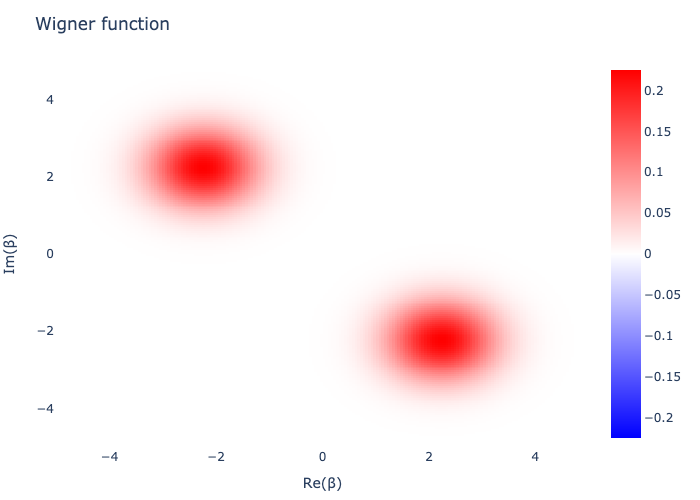

In [238]:
xvec = range(-5, 5, length=200)
plot_wigner(vec2mat(states[end]), xvec, xvec)

In [380]:
rates, states = get_lowlying(N, G, Delta, tg, k1, kphi, nev, sigma);
ρ0p = states[1][1]
ρ1p = states[1][2]
ρ0m = states[2][1]
ρ1m = states[2][2];

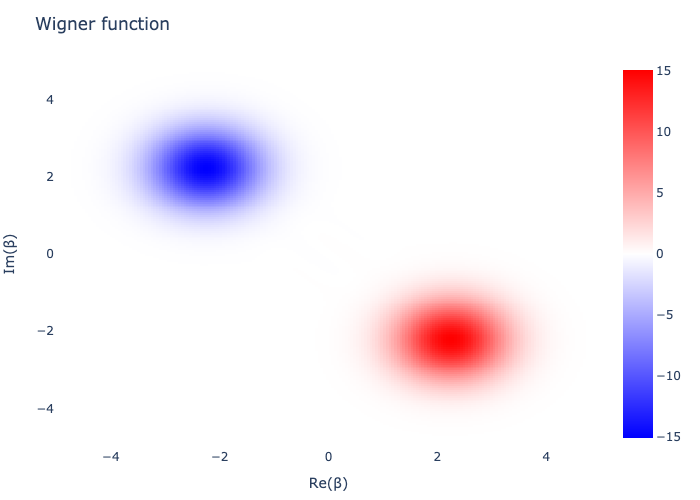

In [381]:
xvec = range(-5, 5, length=200)
plot_wigner(ρ0m, xvec, xvec)

In [385]:
ρ0mp, ρ0mm = spectral_decomposition(ρ0m);

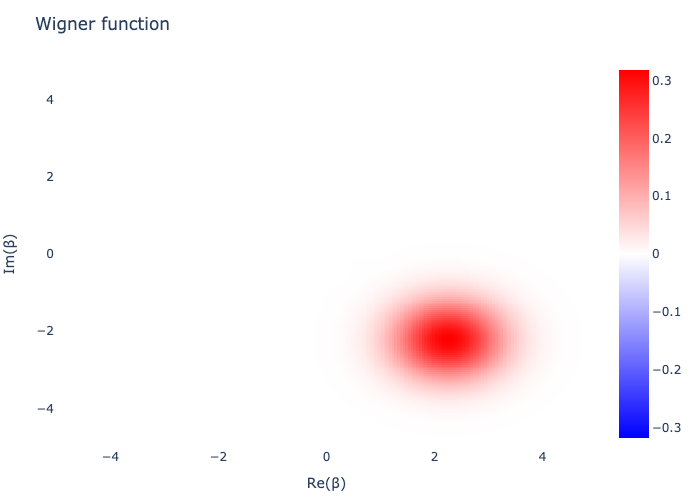

In [386]:
plot_wigner(ρ0mp, xvec, xvec)